In [82]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')


pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
#from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from fbprophet import Prophet

from math import sqrt

import sys
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [83]:
def  date_parser(dt):
    return pd.datetime.strptime(dt, '%Y-%m-%d')
    
data = pd.read_csv("../data/A.csv", parse_dates=['invoice_date'], date_parser=date_parser).set_index('invoice_date')
# data.index = pd.to_datetime(data['invoice_date'], format='%Y-%m-%d')
# data.drop(columns='invoice_date', inplace=True)



In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12728 entries, 2017-05-30 to 2019-01-06
Data columns (total 2 columns):
vehicle_model    12728 non-null object
invoice_line     12728 non-null object
dtypes: object(2)
memory usage: 298.3+ KB


In [85]:
data.head()

,vehicle_model,invoice_line
invoice_date,,
2017-05-30,BAJAJ AVENGER STREET 220,ENGINE OIL
2017-06-02,BAJAJ PULSAR NS 200,ENGINE OIL
2017-06-02,BAJAJ PULSAR NS 200,CHAIN LUBRICATION
2017-05-31,BAJAJ PLATINA,ENGINE OIL
2017-05-31,BAJAJ PLATINA,3M OIL


## Vehicle Model independent spare parts

In [86]:
vm_independent_data = data.drop(columns=['vehicle_model'])
vm_independent_data['invoice_line'].unique()

array(['ENGINE OIL', 'CHAIN LUBRICATION', '3M OIL', 'GENERAL SERVICE',
       'AIR FILTER'], dtype=object)

In [87]:
vm_independent_data.head(5)

,invoice_line
invoice_date,
2017-05-30,ENGINE OIL
2017-06-02,ENGINE OIL
2017-06-02,CHAIN LUBRICATION
2017-05-31,ENGINE OIL
2017-05-31,3M OIL


### Analyse Engine oil

In [88]:
def get_specific_spare_part_data(data: pd.DataFrame, spare_part: str, start_time: str, end_time: str, freq: str) -> pd.DataFrame:
    """
    spare_part: A string that represents spare part
    start_time: A string that represents date like '2017-06-25'
    start_time: A string that represents date like '2017-06-25'
    freq: A string that represents resample frequency
    returns: A DataFrame for the spareparts starting from start_time to end time
    start_time is included but end_time is excluded
    """
    spare_part_data = data.loc[data['invoice_line'] == spare_part]
    spare_part_data = spare_part_data.groupby('invoice_date').count().rename(columns={'invoice_line': 'invoice_count'})
    #### Avoid data from may 2017 and Jan 2019 because data is very less

    spare_part_data = spare_part_data.loc[(spare_part_data.index >= np.datetime64(start_time)) &
                                          (spare_part_data.index < np.datetime64(end_time))
                                         ]

    spare_part_data = spare_part_data.resample(freq).sum()
    return spare_part_data


In [89]:
spare_part_data = get_specific_spare_part_data(vm_independent_data, 'ENGINE OIL', '2017-06-01', '2019-01-01', 'M')
len(spare_part_data)

19

In [90]:
spare_part_data.head()

,invoice_count
invoice_date,
2017-06-30,179
2017-07-31,172
2017-08-31,146
2017-09-30,187
2017-10-31,158


In [91]:
def train_test_split(data: pd.DataFrame, test_size: float) -> (pd.DataFrame, pd.DataFrame):
    """
    data: pd.DataFrame
    test_size: percentage as a floating point number between 0 and 1
    returns: (pd.DataFrame, pd.DataFrame) 
    """
    length = data.shape[0]
    test_size = int(length * test_size)
    train_size = length - test_size
    train_data = data.iloc[0:train_size]
    test_data = data.iloc[train_size:]
    assert len(data) == len(train_data) + len(test_data)
    return train_data, test_data

train_data, test_data = train_test_split(spare_part_data, 0.33)    

In [92]:
train_data.shape

(13, 1)

In [93]:
test_data.shape

(6, 1)

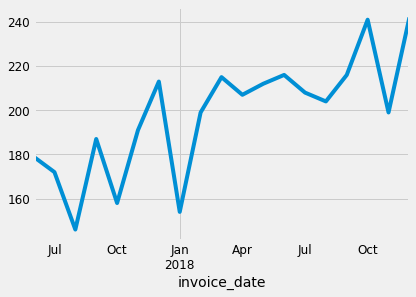

In [94]:
spare_part_data.invoice_count.plot()

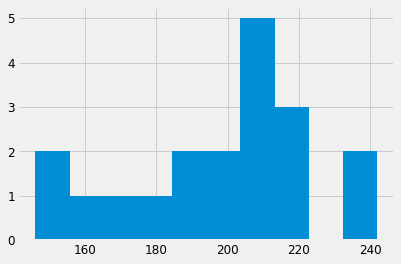

In [95]:
spare_part_data.invoice_count.hist()

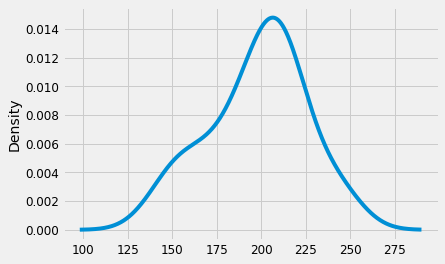

In [96]:
spare_part_data.invoice_count.plot(kind='kde')


In [115]:
def get_arima_model_aic_params(train_data: pd.DataFrame, test_data: pd.DataFrame, steps=None) -> (int, int, int):
    r = range(0, 5)
    min_aic = sys.maxsize

    if not steps:
        steps = len(test_data)
    assert steps == len(test_data)

    for p, d, q in itertools.product(r, r, r):
        try:
            model_arima = ARIMA(train_data, order=(p, d, q))
            model_arima_fit = model_arima.fit()
            pred = model_arima_fit.forecast(steps=steps)[0]
            # print(p, d, q, pred, model_arima_fit.aic)
            if model_arima_fit.aic < min_aic:
                result = (p, d, q, pred, model_arima_fit.aic, model_arima, model_arima_fit)
                min_aic = model_arima_fit.aic
        except:
            pass
    #print(result)
    p, d, q, pred, aic, model_arima, model_arima_fit = result
    print(pred.astype(int))
    print(test_data.invoice_count.values)
    mse = mean_squared_error(test_data, pred)
    rmse = sqrt(mse)
    print('RMSE: {}, MSE:{}'.format(rmse,mse))
    return p, d, q

In [116]:

def get_arima_model_from_p_d_q(train_data: pd.DataFrame, p: int, d: int, q: int) -> 'ArimaResultsWrapper':
    model_arima = ARIMA(train_data, order=(p, d, q))
    model_arima_fit = model_arima.fit()
    return model_arima_fit

def get_arima_model_aic(train_data: pd.DataFrame, test_data: pd.DataFrame, steps=None) -> 'ArimaResultsWrapper':
    p, d, q = get_arima_model_aic_params(train_data, test_data, steps)
    return get_arima_model_from_p_d_q(train_data, p, d, q)


get_arima_model_aic(train_data, test_data)    

[57 58 59 60 61 61]
[57 52 69 70 52 72]
RMSE: 8.324009427524908, MSE:69.28913294952356


In [117]:
def get_arima_model_error_params(train_data: pd.DataFrame, test_data: pd.DataFrame, steps: int=None) -> (int, int, int):
    r = range(0, 5)
    min_error = sys.maxsize
    if not steps:
        steps = len(test_data)
    
    for p, d, q in itertools.product(r, r, r):
        try:
            model_arima = ARIMA(train_data, order=(p, d, q))
            model_arima_fit = model_arima.fit()
            pred = model_arima_fit.forecast(steps=steps)[0]
            mse = mean_squared_error(test_data, pred)
            rmse = sqrt(mse)
            # print(p, d, q, pred, model_arima_fit.aic)
            if rmse < min_error:
                result = (p, d, q, pred, rmse, model_arima, model_arima_fit)
                min_error = rmse
        except:
            pass
    
    (p, d, q, pred, rmse, model_arima, model_arima_fit) = result

    print(pred.astype(int))
    print(test_data.invoice_count.values)
    mse = mean_squared_error(test_data, pred)
    rmse = sqrt(mse)
    print('RMSE: {}, MSE:{}'.format(rmse,mse))
    
    return p, d, q
    

p, d, q = get_arima_model_error_params(train_data, test_data)

[56 57 59 60 62 64]
[57 52 69 70 52 72]
RMSE: 7.943817654058297, MSE:63.104238920928275


In [118]:
def get_arima_model_error(train_data: pd.DataFrame, test_data: pd.DataFrame, steps: int=None) -> (int, int, int):
    p, d, q = get_arima_model_error_params(train_data, test_data, steps)
    return get_arima_model_from_p_d_q(train_data, p, d, q)
    
model_arima_fit = get_arima_model_error(train_data, test_data)

[56 57 59 60 62 64]
[57 52 69 70 52 72]
RMSE: 7.943817654058297, MSE:63.104238920928275


In [119]:
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D2.invoice_count   No. Observations:                   11
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 -45.347
Method:                       css-mle   S.D. of innovations             13.338
Date:                Sun, 13 Oct 2019   AIC                             96.694
Time:                        15:52:51   BIC                             97.888
Sample:                    08-31-2017   HQIC                            95.942
                         - 06-30-2018                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1014      1.115      0.091      0.930      -2.085       2.287
ma.L1.D2.invoice_count    -1.0000      0.227     -4.403      0.002      -1.445      -0.555
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

[57]
[57]
RMSE: 0.9771051805705753, MSE:0.9547345338978565
predicted=57.977105, expected=57.000000
[58]
[52]
RMSE: 6.397801669481055, MSE:40.931866202014575
predicted=58.397802, expected=52.000000
[80]
[69]
RMSE: 11.396619058736917, MSE:129.88292596996553
predicted=80.396619, expected=69.000000
[60]
[70]
RMSE: 9.473151504631467, MSE:89.74059942970142
predicted=60.526848, expected=70.000000
[63]
[52]
RMSE: 11.443627548042528, MSE:130.95661145831784
predicted=63.443628, expected=52.000000
[64]
[72]
RMSE: 7.671425915551993, MSE:58.85077557780273
predicted=64.328574, expected=72.000000
Test MSE: 75.220


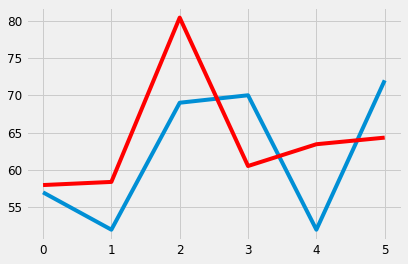

In [120]:
def plot_one_step_ahead():
    train = train_data.invoice_count.values
    test = test_data.invoice_count.values
    history = [x for x in train]

    predictions = list()
    for t in range(len(test)):

        history_df = pd.DataFrame({'invoice_count': history})
        test_df = pd.DataFrame({'invoice_count': test[t:t+1]})
        p, d, q = get_arima_model_aic_params(history_df, test_df, steps=1)
        model = ARIMA(history, order=(p, d, q))
        model_fit = model.fit(disp=0)

        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))

    error = mean_squared_error(test_data, predictions)
    print('Test MSE: %.3f' % error)
    # plot
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()
    
plot_one_step_ahead()

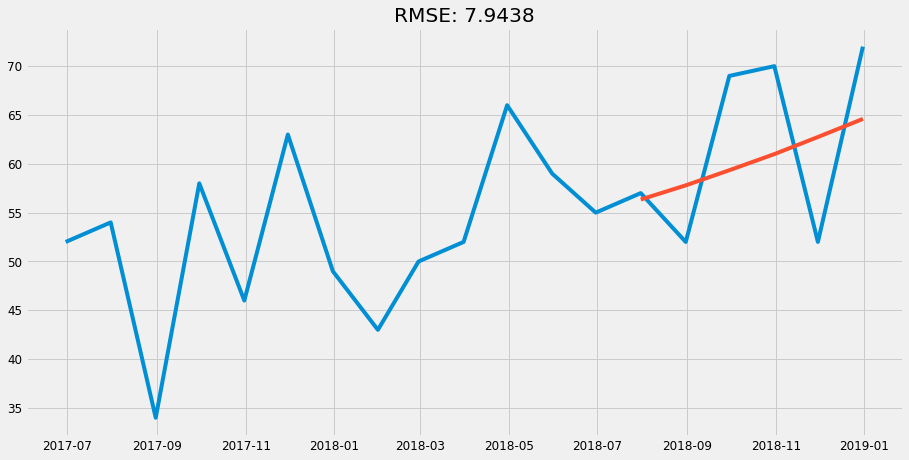

In [121]:
def plot_result(model_arima_fit: 'ARIMAResultsWrapper', train_data: pd.DataFrame, test_data:pd.DataFrame) -> None:

    pred = pd.Series(model_arima_fit.forecast(steps=len(test_data))[0], index=test_data.index)
    
    predicted_data = pd.concat([train_data.invoice_count, 
                      pred])
    rmse = sqrt(mean_squared_error(test_data, pred))
    orig_data = pd.concat([train_data.invoice_count, test_data.invoice_count])
    #print(orig_data)
    plt.figure(figsize=(14, 7))
    plt.plot(orig_data)
    plt.plot(pred)
    plt.title('RMSE: %.4f'% rmse)

plot_result(model_arima_fit, train_data, test_data) 

## Vehicle Model dependent spare parts

In [122]:
def get_model_specific_spare_parts(data):
    vm_dependent_data = data.copy()
    vm_dependent_data['invoice_line_temp'] = vm_dependent_data['vehicle_model'] + '____' + vm_dependent_data['invoice_line']
    vm_dependent_data.drop(columns=['vehicle_model', 'invoice_line'], inplace=True)
    vm_dependent_data.rename(columns={'invoice_line_temp': 'invoice_line'}, inplace=True)
    
    return vm_dependent_data

vm_dependent_data = get_model_specific_spare_parts(data)
vm_dependent_data.head()

,invoice_line
invoice_date,
2017-05-30,BAJAJ AVENGER STREET 220____ENGINE OIL
2017-06-02,BAJAJ PULSAR NS 200____ENGINE OIL
2017-06-02,BAJAJ PULSAR NS 200____CHAIN LUBRICATION
2017-05-31,BAJAJ PLATINA____ENGINE OIL
2017-05-31,BAJAJ PLATINA____3M OIL


In [123]:
vm_dependent_data['invoice_line'].unique()[0:5]

array(['BAJAJ AVENGER STREET 220____ENGINE OIL',
       'BAJAJ PULSAR NS 200____ENGINE OIL',
       'BAJAJ PULSAR NS 200____CHAIN LUBRICATION',
       'BAJAJ PLATINA____ENGINE OIL', 'BAJAJ PLATINA____3M OIL'],
      dtype=object)

In [124]:
vm_dependent_data['invoice_line'].value_counts().head()

BAJAJ PULSAR 150____ENGINE OIL            1066
BAJAJ PULSAR 150____CHAIN LUBRICATION      970
BAJAJ PULSAR 150____GENERAL SERVICE        654
BAJAJ AVENGER STREET 220____ENGINE OIL     591
BAJAJ PULSAR 150____AIR FILTER             554
Name: invoice_line, dtype: int64

### Analyse Engine oil BAJAJ PULSAR 150____ENGINE OIL



In [125]:
spare_part_data = get_specific_spare_part_data(vm_dependent_data, 'BAJAJ PULSAR 150____ENGINE OIL', '2017-06-01', '2019-01-01', 'M')
spare_part_data.head()

,invoice_count
invoice_date,
2017-06-30,52
2017-07-31,54
2017-08-31,34
2017-09-30,58
2017-10-31,46


In [126]:
train_data, test_data = train_test_split(spare_part_data, 0.33)    

In [127]:
train_data.shape

(13, 1)

In [128]:
test_data.shape

(6, 1)

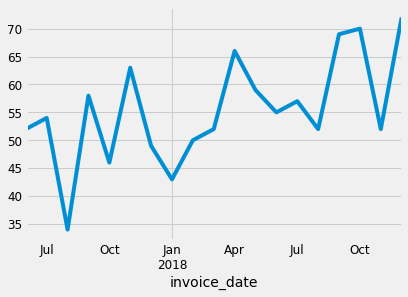

In [129]:
spare_part_data.invoice_count.plot()

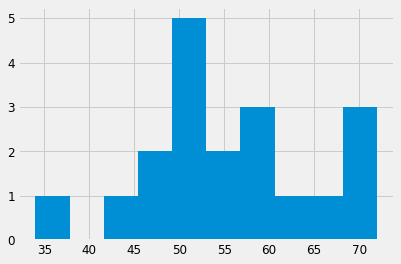

In [130]:
spare_part_data.invoice_count.hist()

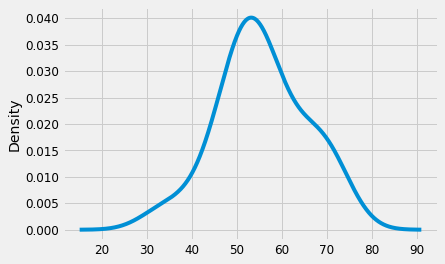

In [131]:
spare_part_data.invoice_count.plot(kind='kde')


In [132]:

get_arima_model_aic(train_data, test_data)

[57 58 59 60 61 61]
[57 52 69 70 52 72]
RMSE: 8.324009427524908, MSE:69.28913294952356


In [134]:
model_arima_fit = get_arima_model_error(train_data, test_data)

[56 57 59 60 62 64]
[57 52 69 70 52 72]
RMSE: 7.943817654058297, MSE:63.104238920928275


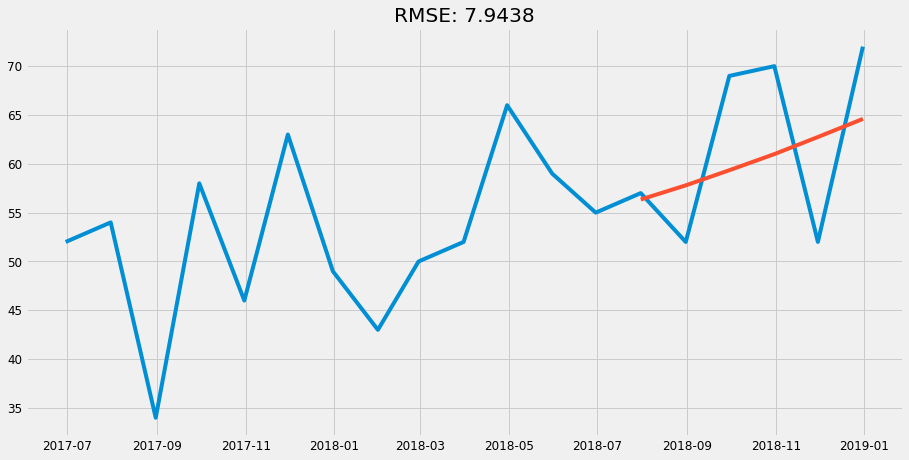

In [135]:
plot_result(model_arima_fit, train_data, test_data) 